A single notebook didn't have enough processing power for all the images and models to run at once

In [1]:
from google.colab import drive
from google.colab import files
from google.colab.patches import cv2_imshow

import os
import warnings
import random
from datetime import date
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import PIL
import urllib
import cv2
from skimage.color import rgb2gray
import skimage.io as skio
from skimage.feature import hog

import scipy as sc
import sklearn as sk
import tensorflow as tf
# import tensorflow_addons as tfa

%matplotlib inline

In [2]:
# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Paths
main_path = "/content/drive/MyDrive/"

project_path = "w281_final_project/"
data_path_benign = "Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/"
data_path_malignant = "Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/"
save_path = "".join([date.today().strftime('%Y%m%d'), "_baseline_models/"])

project_path = "".join([main_path, project_path])
data_path_benign = "".join([project_path, data_path_benign])
data_path_malignant = "".join([project_path, data_path_malignant])
save_path = "".join([project_path, save_path])

# Sanity Check
print("project path: ", project_path)
print("data path benign: ", data_path_benign)
print("data path malignant: ", data_path_malignant)
print("save path: ", save_path)

project path:  /content/drive/MyDrive/w281_final_project/
data path benign:  /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/
data path malignant:  /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/
save path:  /content/drive/MyDrive/w281_final_project/20230424_baseline_models/


In [4]:
# Benign and Malignant Directories
benign_directory = "".join([data_path_benign, "SOB/"])
malignant_directory = "".join([data_path_malignant, "SOB/"])

print("SOB benign", benign_directory)
print("SOB malignant", malignant_directory)

SOB benign /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/
SOB malignant /content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/


In [5]:
# Folders & Resolution
forty = "40X"
one_hundred = "100X"
two_hundred = "200X"
four_hundred = "400X"

In [6]:
# pickle object for later
import pickle

def pickler(ob, pklFileName):
    """ 
      Create pickle object to load later or in different environments for use later

      ob: object, python object intended to pickle
      pklFileName: string, name of the pickle file e.g. "User/content/drive/209/ThisDataFrame.pkl"
    """

    with open(pklFileName, "wb+") as f:
        pickle.dump(ob, f)


def load_pickles(pklFilePath):
    """
      path: string, path to object
      pklFileName: string, pickle file name with extension .pkl
    """

    return pd.read_pickle(pklFilePath)

In [7]:
class fileMetaData: 
  def __init__(fileName): 
    self.fileName = fileName

In [8]:
labels = {
    "BIOPSY_PROCEDURE": "", 
    "TUMOR_CLASS": "", 
    "TUMOR_TYPE":"", 
    "YEAR": "",
    "SLIDE_ID": "", 
    "MAGNIFICATION": "",
    "SEQ":""
}

In [9]:
# categories
categories = {'B': 'Benign',
              'M': 'Malignant',
              'A': 'Adenosis',
              'F': 'Fibroadenoma',
              'TA': 'Tubular Adenoma',
              'PT': 'Phyllodes Tumor',
              'DC': 'Ductal Carcinoma',
              'LC': 'Lobular Carcinoma',
              'MC': 'Mucinous Carcinoma (Colloid)',
              'PC': 'Papillary Carcinoma'}

In [10]:
def metaDataCreator(fileName):
  """
    Separate out the parts of a file name to get the annotations
  """

  metaKeys = ['BIOPSY_PROCEDURE',
            'TUMOR_CLASS',
            'TUMOR_TYPE',
            'YEAR',
            'SLIDE_ID',
            'MAGNIFICATION',
            'SEQ']

  test = str.split(fileName, sep = ".")[0]
  test = str.split(test, sep = "_")
  test2 = str.split(test[-1], sep = "-")
  test = test[:-1]
  metaValues = test + test2
  if len(metaValues) == 7: 
    return {metaKeys[i]:metaValues[i] for i in range(len(metaValues))}
  else: 
    return None

In [11]:
file = "SOB_B_A-14-22549AB-100-001.png"
metaDataCreator(file)

{'BIOPSY_PROCEDURE': 'SOB',
 'TUMOR_CLASS': 'B',
 'TUMOR_TYPE': 'A',
 'YEAR': '14',
 'SLIDE_ID': '22549AB',
 'MAGNIFICATION': '100',
 'SEQ': '001'}

In [12]:
Benign_fileList = os.listdir(benign_directory)
Malignant_fileList = os.listdir(malignant_directory)
Malignant_fileList

['ductal_carcinoma',
 'lobular_carcinoma',
 'mucinous_carcinoma',
 'papillary_carcinoma']

In [13]:
def fileNameGetter(f):
  return f.split("/")[-1]

In [14]:
df = load_pickles(os.path.join("/content/drive/MyDrive/w281_final_project/Data/pickles", "metaData.pkl"))

# starting with 40x
df.query('MAGNIFICATION == "40"').reset_index(inplace=True, drop = True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BIOPSY_PROCEDURE  7909 non-null   object
 1   TUMOR_CLASS       7909 non-null   object
 2   TUMOR_TYPE        7909 non-null   object
 3   YEAR              7909 non-null   object
 4   SLIDE_ID          7909 non-null   object
 5   MAGNIFICATION     7909 non-null   object
 6   SEQ               7909 non-null   object
 7   FULL_PATH         7909 non-null   object
 8   BASE_NAME         7909 non-null   object
dtypes: object(9)
memory usage: 556.2+ KB


,BIOPSY_PROCEDURE,TUMOR_CLASS,TUMOR_TYPE,YEAR,SLIDE_ID,MAGNIFICATION,SEQ,FULL_PATH,BASE_NAME
0,SOB,B,A,14,22549AB,100,004,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-004.png
1,SOB,B,A,14,22549AB,100,002,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-002.png
2,SOB,B,A,14,22549AB,100,003,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-003.png
3,SOB,B,A,14,22549AB,100,001,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-001.png
4,SOB,B,A,14,22549AB,100,007,/content/drive/MyDrive/w281_final_project/Data...,SOB_B_A-14-22549AB-100-007.png


In [15]:
print("Total entries in the dataset", len(df))

Total entries in the dataset 7909


In [16]:
### Create a list of fileNames for images in each category of benign or malignant directory
def fileListGenerator(directories, benign = True):
  """
  Input: List of directories within Benign or Malignant folder
  Output: An array of lists for each image
  """
  imageNames = { d: None for d in directories}
  for i in directories:
    if benign:
      directory = "".join([benign_directory, i])
      fileList = glob.glob(directory + "/**/*.png", recursive=True)
      imageNames[i] = fileList
    else:
      directory = "".join([malignant_directory, i])
      fileList = glob.glob(directory + "/**/*.png", recursive=True)
      imageNames[i] = fileList
  return imageNames

In [17]:
### Store all benign png images into a seperate array with metadata
def separate_tumors(inputLst):
  """
  Input: List of Directories in Benign or Malignant Folder
  Output: List of Dictionaries containing the metadata for each image un sub directories
  """
  tumor_array = []
  for i in inputLst:
    new_directory = "".join([benign_directory, i])
    fileList = glob.glob(new_directory + "/**/*.png", recursive=True)
    files = list(map(fileNameGetter, fileList))
    tumor_array.append({file:metaDataCreator(file) for file in files})
  return tumor_array

In [18]:
### Create a dictionary containing the directory for each image and the tumor label
benign_files = fileListGenerator(Benign_fileList)
malignant_files = fileListGenerator(Malignant_fileList, benign=False)
benign_files

{'adenosis': ['/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-007.png',
  '/content/drive/MyDrive/w281_final_project/Data/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/aden

### Benign Dataset

In [19]:
### Intialize the File Path and label into separate datasets to load images
benign_adenosis_dataset = pd.DataFrame(benign_files.get('adenosis'), columns=['full_path']) # Benign Adenosis Tumors
benign_fibroadenoma_dataset = pd.DataFrame(benign_files.get('fibroadenoma'), columns=['full_path']) # Benign Fibroadenoma Tumors
benign_phyllodes_tumor_dataset = pd.DataFrame(benign_files.get('phyllodes_tumor'), columns=['full_path']) # Benign Phyllodes Tumors
benign_tubular_adenoma_dataset = pd.DataFrame(benign_files.get('tubular_adenoma'), columns=['full_path']) # Benign Tubular Adenoma Tumors
print(len(benign_adenosis_dataset['full_path']))
benign_adenosis_dataset['label'] = 'A'
benign_fibroadenoma_dataset['label'] = 'F'
benign_phyllodes_tumor_dataset['label'] = 'PT'
benign_tubular_adenoma_dataset['label'] = 'TA'
benign_adenosis_dataset.head()

444


,full_path,label
0,/content/drive/MyDrive/w281_final_project/Data...,A
1,/content/drive/MyDrive/w281_final_project/Data...,A
2,/content/drive/MyDrive/w281_final_project/Data...,A
3,/content/drive/MyDrive/w281_final_project/Data...,A
4,/content/drive/MyDrive/w281_final_project/Data...,A


In [20]:
pandas_frames = [benign_adenosis_dataset, benign_fibroadenoma_dataset, benign_phyllodes_tumor_dataset, benign_tubular_adenoma_dataset]
full_benign_dataset = pd.concat(pandas_frames)
full_benign_dataset["class"] = 1
full_benign_dataset.head()

,full_path,label,class
0,/content/drive/MyDrive/w281_final_project/Data...,A,1
1,/content/drive/MyDrive/w281_final_project/Data...,A,1
2,/content/drive/MyDrive/w281_final_project/Data...,A,1
3,/content/drive/MyDrive/w281_final_project/Data...,A,1
4,/content/drive/MyDrive/w281_final_project/Data...,A,1


In [21]:
def magnification(dataset, filePaths):
  """
  Input:
  dataset - Dataset for which image paths are extracted from 
  filePaths - List of full image paths
  Output: 
  dataset with magnification label
  """
  find = re.compile('([-\w]+\.(?:jpg|gif|png))')
  magnifications = []
  for i in filePaths:
    image_file = re.search(find, i)[0]
    meta_data = metaDataCreator(image_file)
    magnifications.append(int(meta_data.get('MAGNIFICATION')))
  dataset["magnification"] = magnifications

In [22]:
magnification(full_benign_dataset, full_benign_dataset['full_path'])
full_benign_dataset

,full_path,label,class,magnification
0,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
1,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
2,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
3,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
4,/content/drive/MyDrive/w281_final_project/Data...,A,1,100
...,...,...,...,...
564,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40
565,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40
566,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40
567,/content/drive/MyDrive/w281_final_project/Data...,TA,1,40


### Malignant Dataset

In [23]:
malignant_ductal_carcinoma_dataset = pd.DataFrame(malignant_files.get('ductal_carcinoma'), columns=['full_path']) # Malignant Ductal Carcinoma Tumors
malignant_lobular_carcinoma_dataset = pd.DataFrame(malignant_files.get('lobular_carcinoma'), columns=['full_path']) # Malignant Lobuular Carcinoma Tumors
malignant_mucinous_carcinoma_tumor_dataset = pd.DataFrame(malignant_files.get('mucinous_carcinoma'), columns=['full_path']) # Malignant Mucinous Carcinoma Tumors
malignant_papillary_carcinoma_adenoma_dataset = pd.DataFrame(malignant_files.get('papillary_carcinoma'), columns=['full_path']) # Malignant Papillary Carcinoma Tumors
print(len(malignant_ductal_carcinoma_dataset['full_path']))
malignant_ductal_carcinoma_dataset['label'] = 'DC'
malignant_lobular_carcinoma_dataset['label'] = 'LC'
malignant_mucinous_carcinoma_tumor_dataset['label'] = 'MC'
malignant_papillary_carcinoma_adenoma_dataset['label'] = 'PC'
malignant_ductal_carcinoma_dataset.head()

3451


,full_path,label
0,/content/drive/MyDrive/w281_final_project/Data...,DC
1,/content/drive/MyDrive/w281_final_project/Data...,DC
2,/content/drive/MyDrive/w281_final_project/Data...,DC
3,/content/drive/MyDrive/w281_final_project/Data...,DC
4,/content/drive/MyDrive/w281_final_project/Data...,DC


In [24]:
malignant_pandas_frames = [malignant_ductal_carcinoma_dataset, malignant_lobular_carcinoma_dataset, malignant_mucinous_carcinoma_tumor_dataset, malignant_papillary_carcinoma_adenoma_dataset]
full_malignant_dataset = pd.concat(malignant_pandas_frames)
full_malignant_dataset["class"] = 0
magnification(full_malignant_dataset, full_malignant_dataset['full_path'])
full_malignant_dataset.head()

,full_path,label,class,magnification
0,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
1,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
2,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
3,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
4,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100


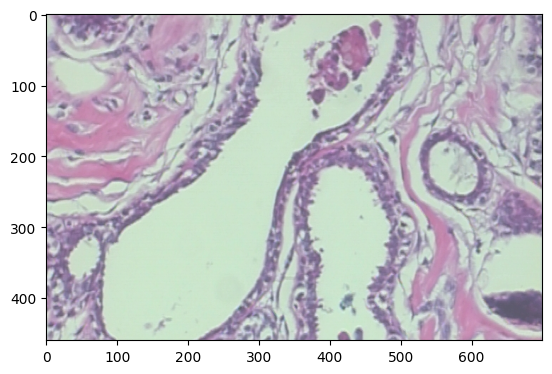

In [25]:
### Example Image
next_directory = "".join([benign_directory, 'adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png'])
img1 = plt.imread(next_directory)
# img2 = plt.imread(benign_files[0])
plt.imshow(img1, cmap='gray')

### Load & Augment Images

In [26]:
from sklearn.model_selection import train_test_split
from skimage import exposure, data, img_as_float, img_as_ubyte
from scipy import signal
from scipy.ndimage import convolve, gaussian_filter
from skimage.feature import hog

In [27]:
full_training_dataset = pd.concat([full_benign_dataset, full_malignant_dataset])
full_training_dataset = full_training_dataset.sample(frac=1).reset_index(drop=True)
full_training_dataset.head()

,full_path,label,class,magnification
0,/content/drive/MyDrive/w281_final_project/Data...,DC,0,100
1,/content/drive/MyDrive/w281_final_project/Data...,MC,0,40
2,/content/drive/MyDrive/w281_final_project/Data...,PC,0,40
3,/content/drive/MyDrive/w281_final_project/Data...,A,1,40
4,/content/drive/MyDrive/w281_final_project/Data...,LC,0,400


In [28]:
### Number of individual labels of benign and malignant tumors
num_labels = full_training_dataset['label'].unique()
num_labels

array(['DC', 'MC', 'PC', 'A', 'LC', 'TA', 'F', 'PT'], dtype=object)

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_labels = le.fit(num_labels)
list_of_encoded_labels = encoded_labels.transform(full_training_dataset['label'])
decoded_labels = encoded_labels.inverse_transform(list_of_encoded_labels)
print(decoded_labels)
print(list_of_encoded_labels)

full_training_dataset["encoded_labels"] = list_of_encoded_labels

['DC' 'MC' 'PC' ... 'DC' 'PC' 'F']
[1 4 5 ... 1 5 2]


In [30]:
### Split datasets into train and validation sets
def train_test_split_data(dataset, x_column, y_column):
  """
  Inputs:
  Dataset - pandas dataframe with directory paths and labels
  Outputs:
  train_data
  train_labels
  valid_data
  valid_labels
  """
  X = dataset[x_column]
  Y = dataset[y_column]
  train_data, valid_data, train_label, valid_label = train_test_split(X, Y, test_size = 0.25, shuffle=True, random_state=44)
  return train_data, valid_data, train_label, valid_label

In [31]:
### Histogram Equalization Contrast
def histogram_equalization_grayscale(im):
  # img_cdf, bins = exposure.cumulative_distribution(im, 256)
  # container = np.zeros(256)
  # print(img_cdf)
  # container[:bins] = img_cdf
  # holding_image = np.empty(im.shape)
  # for i in range(im.shape[0]):
  #   for y in range(im.shape[1]):
  #     holding_image[i][y] = container[im[i][y]]
  # equalized_image = holding_image
  # equalized_image = img_as_ubyte(equalized_image)
  im = np.resize(im, (400,640))
  equalized_image = exposure.equalize_hist(im, 256) 
  return equalized_image

In [32]:
### Image Sharpen Contrast
def sharpen_image(image):
  # Blur filter from previous work
  image = np.resize(image, (400,640,3))
  blurred_image = gaussian_filter(image, 3)
  high_frequency_image = image - blurred_image
  sharpened_image = image + high_frequency_image
  return sharpened_image

In [33]:
def edge_detection(image):
  # Construct a HOG for each image and edge detection

  filter = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
  gradients = sc.ndimage.convolve(image, filter)

  histograms = hog(image, orientations = 8, pixels_per_cell=(16,16))

  return gradients, histograms

In [34]:
### Create and augment an array of images from a dataset
def load_images(filePaths):
  """
  Inputs:
  filePaths - list of directory paths to images
  Outputs:
  an array of loaded images to be used within the model
  """
  image_container = []
  for i in filePaths:
    im = plt.imread(i)
    im = rgb2gray(im)
    im = img_as_ubyte(im)
    im = histogram_equalization(im)
    image_container.append(im)
  return image_container

In [35]:
### Create image arrays for inputs into the model using histogram equalization
def read_and_grayscale_images(image_paths, labels):
  img1 = tf.io.read_file(image_paths)
  img1 = tf.image.decode_image(img1, channels=3, dtype=tf.float32)
  img1 = tf.image.rgb_to_grayscale(img1)
  return img1, labels

In [36]:
### Decode and read images for all the image files in color
def read_images(image_paths, labels):
  img1 = tf.io.read_file(image_paths)
  img1 = tf.image.decode_image(img1, channels=3, dtype=tf.float32)
  return img1, labels

In [37]:
### Decode and read images for all the image files in color add saturation
def read_images_gamma(image_paths, labels):
  img1 = tf.io.read_file(image_paths)
  img1 = tf.image.decode_image(img1, channels=3, dtype=tf.float32)
  img1 = tf.image.adjust_gamma(img1, 1.5)
  img1 = tf.image.resize_with_crop_or_pad(img1, 400,640)
  return img1, labels

In [38]:
def create_equalized_image_set(ds, num_images = 5): 
    # create preview of images with labels
    images = []
    for i, t in enumerate(ds.take(num_images)): 
        images.append(
            {'label': t[1].numpy(), 
            'im' : histogram_equalization_grayscale(t[0].numpy())}
        )

    return images

In [39]:
def create_sharpened_image_set(ds, num_images = 5): 
    # create preview of images with labels
    images = []
    for i, t in enumerate(ds.take(num_images)): 
        images.append(
            {'label': t[1].numpy(), 
            'im' : sharpen_image(t[0].numpy())}
        )

    return images

In [40]:
def create_edges_image_set(ds, num_images = 5): 
    # create preview of images with labels
    images = []
    for i, t in enumerate(ds.take(num_images)): 
        images.append(
            {'label': t[1].numpy(), 
            'im' : edge_detection(t[0].numpy())}
        )

    return images

In [41]:
def create_image_set(ds, num_images = 5): 
    """ Create preview of images with labels 
    Takes the num_images from the dataset for viewing in plots
    
    Args: 
    ds (tensorflow dataset): tensorflow dataset with images
    """
    
    images = []
    for i, t in enumerate(ds.take(num_images)): 
        images.append(
            {'label': t[1].numpy(), 
            'im' : t[0].numpy()}
        )

    return images

In [42]:
full_training_dataset = full_training_dataset.sample(frac=1)
full_training_dataset.head()
print(len(full_training_dataset))
file_paths = full_training_dataset['full_path'].values
class_labels =  full_training_dataset['class'].values
tf_dataset = tf.data.Dataset.from_tensor_slices((file_paths, class_labels))
tf_dataset

7909


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [43]:
dataset_size = tf_dataset.cardinality()
train_size = int(0.7 * len(full_training_dataset))
val_size = int(0.10 * len(full_training_dataset))
test_size = int(0.20 * len(full_training_dataset))

dataset_size
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)
val_dataset = test_dataset.take(val_size)
test_dataset = test_dataset.skip(val_size)

print(train_size)
print(train_dataset.cardinality().numpy())
print(val_dataset.cardinality().numpy())
print(test_dataset.cardinality().numpy())

5536
5536
790
1583


In [44]:
tf_color_dataset = train_dataset.map(read_images_gamma)
train_gamma_color_dataset = create_image_set(tf_color_dataset, 300)
train_gamma_color_dataset[:2]

[{'label': 0,
  'im': array([[[0.91878796, 0.81779987, 0.8068228 ],
          [0.8846908 , 0.7850175 , 0.7850175 ],
          [0.8903438 , 0.79045016, 0.79045016],
          ...,
          [0.8288263 , 0.742009  , 0.742009  ],
          [0.8343579 , 0.7473408 , 0.7473408 ],
          [0.81230515, 0.7366899 , 0.7313837 ]],
  
         [[0.8903438 , 0.79045016, 0.7795974 ],
          [0.90168566, 0.8013528 , 0.79045016],
          [0.89600873, 0.81230515, 0.7958952 ],
          ...,
          [0.8343579 , 0.7473408 , 0.7473408 ],
          [0.81230515, 0.7366899 , 0.7313837 ],
          [0.7958952 , 0.7208095 , 0.7050449 ]],
  
         [[0.8903438 , 0.79045016, 0.7795974 ],
          [0.8903438 , 0.8068228 , 0.79045016],
          [0.8790499 , 0.79045016, 0.79045016],
          ...,
          [0.81779987, 0.742009  , 0.7366899 ],
          [0.81230515, 0.7366899 , 0.7313837 ],
          [0.81230515, 0.7366899 , 0.7208095 ]],
  
         ...,
  
         [[0.25298223, 0.06924564, 0.46475

In [45]:
tf_valid_dataset = val_dataset.map(read_images_gamma)
valid_gamma_color_dataset = create_image_set(tf_valid_dataset, 50)
valid_gamma_color_dataset[:2]

[{'label': 0,
  'im': array([[[0.8068228 , 0.7313837 , 0.8013528 ],
          [0.7958952 , 0.7208095 , 0.79045016],
          [0.7958952 , 0.7208095 , 0.79045016],
          ...,
          [0.8233069 , 0.7687947 , 0.8288263 ],
          [0.8343579 , 0.7795974 , 0.8399018 ],
          [0.8343579 , 0.7795974 , 0.8399018 ]],
  
         [[0.8068228 , 0.7313837 , 0.8013528 ],
          [0.7958952 , 0.7208095 , 0.79045016],
          [0.7958952 , 0.7208095 , 0.79045016],
          ...,
          [0.8233069 , 0.7687947 , 0.8288263 ],
          [0.8343579 , 0.7795974 , 0.8399018 ],
          [0.8399018 , 0.7850175 , 0.8343579 ]],
  
         [[0.7958952 , 0.7313837 , 0.7958952 ],
          [0.79045016, 0.7155418 , 0.7850175 ],
          [0.79045016, 0.7155418 , 0.7850175 ],
          ...,
          [0.8343579 , 0.7687947 , 0.8343579 ],
          [0.8343579 , 0.7687947 , 0.8343579 ],
          [0.8343579 , 0.7795974 , 0.8399018 ]],
  
         ...,
  
         [[0.7366899 , 0.6998159 , 0.73668

In [46]:
tf_test_dataset = test_dataset.map(read_images_gamma)
test_gamma_color_dataset = create_image_set(tf_test_dataset, 100)
test_gamma_color_dataset[:2]

[{'label': 0,
  'im': array([[[0.75804245, 0.6893969 , 0.742009  ],
          [0.7850175 , 0.6893969 , 0.75268525],
          [0.7958952 , 0.6998159 , 0.7634123 ],
          ...,
          [0.7155418 , 0.6330332 , 0.6893969 ],
          [0.7050449 , 0.62295854, 0.6790302 ],
          [0.7155418 , 0.6330332 , 0.684207  ]],
  
         [[0.7366899 , 0.6687159 , 0.7208095 ],
          [0.7473408 , 0.66357857, 0.7208095 ],
          [0.7634123 , 0.6790302 , 0.7366899 ],
          ...,
          [0.6945999 , 0.6129379 , 0.6790302 ],
          [0.6790302 , 0.5980089 , 0.66357857],
          [0.6893969 , 0.60794795, 0.66357857]],
  
         [[0.7473408 , 0.66357857, 0.7208095 ],
          [0.7473408 , 0.66357857, 0.7208095 ],
          [0.7634123 , 0.6790302 , 0.7473408 ],
          ...,
          [0.6998159 , 0.60794795, 0.6790302 ],
          [0.6945999 , 0.60297155, 0.67386645],
          [0.6790302 , 0.5980089 , 0.6533435 ]],
  
         ...,
  
         [[0.67386645, 0.5539651 , 0.66357

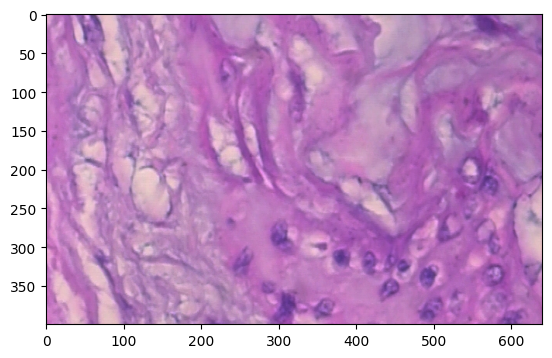

In [47]:
plt.imshow(train_gamma_color_dataset[4]['im'])

In [48]:
all_training_images_gamma_color = np.array([i['im'] for i in train_gamma_color_dataset])
all_training_labels_gamma_color = np.array([i['label'] for i in train_gamma_color_dataset])

all_valid_images_gamma_color = np.array([i['im'] for i in valid_gamma_color_dataset])
all_valid_labels_gamma_color = np.array([i['label'] for i in valid_gamma_color_dataset])

all_test_images_gamma_color = np.array([i['im'] for i in test_gamma_color_dataset])
all_test_labels_gamma_color = np.array([i['label'] for i in test_gamma_color_dataset])

print(all_training_images_gamma_color.shape)
print(all_training_labels_gamma_color.shape)

print(all_valid_images_gamma_color.shape)

(300, 400, 640, 3)
(300,)
(50, 400, 640, 3)


In [49]:
### Binary dataset set up
binary_train_data, binary_valid_data, binary_train_labels, binary_valid_labels = train_test_split_data(full_training_dataset.iloc[:5000], "full_path", "class")

print(binary_train_data[:5])
print(binary_train_labels[:5])

6675    /content/drive/MyDrive/w281_final_project/Data...
1720    /content/drive/MyDrive/w281_final_project/Data...
1937    /content/drive/MyDrive/w281_final_project/Data...
2184    /content/drive/MyDrive/w281_final_project/Data...
3400    /content/drive/MyDrive/w281_final_project/Data...
Name: full_path, dtype: object
6675    1
1720    0
1937    0
2184    1
3400    1
Name: class, dtype: int64


In [50]:
binary_train_data.index = np.arange(len(binary_train_data))
binary_train_labels.index = np.arange(len(binary_train_labels))
binary_valid_data.index = np.arange(len(binary_valid_data))
binary_valid_labels.index = np.arange(len(binary_valid_data))

### Creating Models

#### Binary Models

In [51]:
### Baseline TensorFlow model
def create_baseline_cnn(input_shape = (400,640,3), hidden_layers = 0, filters = 4, kernel_size = 3, learning_rate = 0.001, embedding_size = 0):
  
  input_layer = tf.keras.layers.Input(input_shape, batch_size=3, name="Input_Layer")
  convolve_layer = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu')(input_layer)
  drop_layer = tf.keras.layers.Dropout(0.03)(convolve_layer)
  convolve_layer_2 = tf.keras.layers.Conv2D(filters= filters, kernel_size=3, activation='relu')(drop_layer)
  flatten = tf.keras.layers.Flatten()(convolve_layer_2)
  flatten = tf.keras.layers.Dense(128, activation="relu")(flatten)
  flatten = tf.keras.layers.Dense(64, activation="relu")(flatten)
  flatten = tf.keras.layers.Dense(32, activation="relu")(flatten)
  compress = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)
  base_model = tf.keras.Model(inputs=[input_layer], outputs=[compress])
  base_model.compile(optimizer='sgd', loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return base_model

In [52]:
### Baseline Average CNN Model
def create_average_cnn(input_shape = (400, 640, 3), hidden_layers = 3, filters = 3, kernel_size = 3, learning_rate = 0.001, dropout_rate = 0.1):

  input_layer = tf.keras.layers.Input(shape=input_shape, batch_size = 3, name="Starting_Layer")

  # for i in range(hidden_layers):
  convolve1 = tf.keras.layers.Conv2D(filters=128, kernel_size=kernel_size, activation="ReLU", name = "Average_layer")(input_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve1)
  convolve2 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, activation="ReLU")(avg_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve2)
  convolve3 = tf.keras.layers.Conv2D(filters=32, kernel_size=kernel_size, padding='valid', activation='relu')(avg_layer)
  avg_layer = tf.keras.layers.AveragePooling2D()(convolve3)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(avg_layer)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(avg_layer)
  # flatten_layer = tf.keras.layers.Flatten()(global_average_layer)
  avg_layer = tf.keras.layers.Dropout(dropout_rate)(global_average_layer)
  # flatten = tf.keras.layers.Dense(128, activation="relu")(avg_layer)
  # flatten = tf.keras.layers.Dense(64, activation="relu")(flatten)
  # flatten = tf.keras.layers.Dense(32, activation="relu")(avg_layer)
  compress_layer = tf.keras.layers.Dense(8, activation = "ReLU")(avg_layer)
  classification_layer = tf.keras.layers.Dense(1, activation = "sigmoid")(compress_layer)
  model = tf.keras.Model(inputs=[input_layer], outputs=[classification_layer])

  model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),
                                 loss = "binary_crossentropy",
                                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model

In [53]:
def create_max_cnn_model(input_shape = (400, 640, 3), hidden_layers=3, filters=5, kernel_size=3, learning_rate=0.001, dropout_rate=0.1):

  input_layer = tf.keras.layers.Input(input_shape, batch_size=32, name="Starting_Layer", dtype=tf.float64)
  convolve_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu')(input_layer)
  max_1 = tf.keras.layers.MaxPool2D()(convolve_1)
  convolve_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu')(max_1)
  max_2 = tf.keras.layers.MaxPool2D()(convolve_2)
  convolve_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu')(max_2)
  max_3 = tf.keras.layers.MaxPool2D()(convolve_3)
  slight_adjustment = tf.keras.layers.Dropout(dropout_rate)(max_3)

  flatten = tf.keras.layers.GlobalMaxPooling2D()(slight_adjustment)
  flatten = tf.keras.layers.Dense(128, activation="relu")(flatten)
  flatten = tf.keras.layers.Dense(64, activation="relu")(flatten)
  flatten = tf.keras.layers.Dense(32, activation="relu")(flatten)
  compress = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)
  model = tf.keras.Model(inputs=[input_layer], outputs=[compress])

  model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate),
                loss = "binary_crossentropy",
                metrics = ['Accuracy', tf.keras.metrics.Precision()])
  
  return model

In [54]:
def create_resnet_model(input_shape = (400, 640, 3), filters=3, kernel_size=3, learning_rate=0.001, dropout_rate=0.1):

  input_layer = tf.keras.layers.Input(input_shape, batch_size=32, name="Initial_input", dtype=tf.float64)

  weights = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu')(input_layer)
  norm_1 = tf.keras.layers.BatchNormalization(axis=1, synchronized=True)(weights)

  added_layer = tf.keras.layers.Add()([input_layer, norm_1])

  weights_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu' )(added_layer)
  norm_2 = tf.keras.layers.BatchNormalization(axis=1, synchronized=True)(weights_2)

  added_layer_2 = tf.keras.layers.Add()([input_layer, norm_2])

  weights_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu')(added_layer_2)
  norm_3 = tf.keras.layers.BatchNormalization(axis=1, synchronized=True)(weights_3)

  added_layer_3 = tf.keras.layers.Add()([input_layer, norm_3])
  drop_layer = tf.keras.layers.Dropout(dropout_rate)(added_layer_3)

  flatten = tf.keras.layers.GlobalAveragePooling2D()(drop_layer)
  compress = tf.keras.layers.Dense(1, activation="sigmoid")(flatten)
  model = tf.keras.Model(inputs = [input_layer], outputs=[compress])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss = "binary_crossentropy",
                metrics = ["Accuray", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  
  return model

In [55]:
# baseline_cnn_model = create_baseline_cnn()
average_cnn_model = create_average_cnn()
# max_cnn_model = create_max_cnn_model()
# resnet_cnn_model = create_resnet_model()

In [56]:
# baseline_cnn_model.summary()

In [57]:
average_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Starting_Layer (InputLayer)  [(3, 400, 640, 3)]       0         
                                                                 
 Average_layer (Conv2D)      (3, 398, 638, 128)        3584      
                                                                 
 average_pooling2d (AverageP  (3, 199, 319, 128)       0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (3, 197, 317, 64)         73792     
                                                                 
 average_pooling2d_1 (Averag  (3, 98, 158, 64)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_1 (Conv2D)           (3, 96, 156, 32)          18464 

In [58]:
# max_cnn_model.summary()

In [59]:
# resnet_cnn_model.summary()

In [60]:
# baseline_cnn_model_history = baseline_cnn_model.fit(all_training_images_gamma_color, all_training_labels_gamma_color, validation_data=([all_valid_images_gamma_color, all_valid_labels_gamma_color]), batch_size=32, epochs=4)

In [ ]:
average_cnn_model_history = average_cnn_model.fit(all_training_images_gamma_color, all_training_labels_gamma_color, validation_data=([all_valid_images_gamma_color, all_valid_labels_gamma_color]), batch_size=32, epochs=4)

Epoch 1/4
